## Plot thermal lensing data

Imports

In [1]:
#Import ximea (camera software)
import sys
sys.path.append('C:/XIMEA/API/Python/v3')

import ximea
print('ximea version ', ximea.__version__)
from ximea import xiapi

#import useful things
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import keyboard

# Import HS classes assuming they reside one directory above
hspath = os.path.abspath('..')
if hspath not in sys.path:
    sys.path.append(hspath)

# use the location where you have saved the HWS modules on your own computer
sys.path.append('C:/Users/katel/Documents/honours_project')

from HS_Image import *
from HWS.HS_Centroids import *
from HWS.HS_Gradients import *
from HWS.HS_WFP import *
import HWS.HSM_WFN as HSM_WFN

import time
import scipy.optimize as opt

# for sending notification email
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

ximea version  4.28.00


User Options (make sure these are applicable)

In [2]:
# number of frames to take and average
N = 100

# name of folder to save average images in
folder_name = 'cents_over_time_15_09'
# translation of translation stage
translation = 0 # mm

# size of image taken by HWS (pixels)
img_size = 2048
# distance from CCD array to Heartmann plate
lever_arm = 8.73e-3 # (m)
# magnification due to imaging telescope
magnification = 1/0.509
# pixel size in CCD array
pixel_size = 5.5e-6
# wavelength of SLD light (m)
wavelength = 830e-9
# distance between holes on the Heartmann plate
hole_spacing = 4e-4 # (m)
# origin
origin = 2047/2


# location of this file, where images save to
file_path = os.getcwd()

Functions

In [3]:

def plot_gradients_and_wf(what_grad, wavefront, title):
     '''plot gradients and wavefunctions
     
     Args:
          what_grad (hsg) = gradients to plot
          wavefront (wf) = wavefront deformation to plot
          title (string) = title of plot
        '''

     gspacing = 4 * what_grad.pixel_size

     limits = {}
     limits["x"] = np.array(
          [what_grad.gradients[:,2].min() - gspacing, what_grad.gradients[:,2].max() + gspacing]
     )

     limits["y"] = np.array(
          [what_grad.gradients[:,3].min() - gspacing, what_grad.gradients[:,3].max() + gspacing]
     )

     xaxis = np.arange(limits["x"][0], limits["x"][1], gspacing) * magnification
     yaxis = np.arange(limits["y"][0], limits["y"][1], gspacing) * magnification


     plt.figure(title, figsize=(9.6, 3.8))
     centroids = what_grad.gradients[:,2:]

     gs=gridspec.GridSpec(1,3, width_ratios=[4,4,0.2])
     axn_g = plt.subplot(gs[0])
     axn_w = plt.subplot(gs[1])
     axn_c = plt.subplot(gs[2])

     axn_g.quiver(what_grad.gradients[:,2],what_grad.gradients[:,3],what_grad.gradients[:,0],what_grad.gradients[:,1])
     #axn_g.quiver(centroids[:,0], centroids[:,1], hsg_res.gradients[:,0],hsg_res.gradients[:,1])
     axn_g.set_aspect('equal')
     axn_g.set_title('Gradients')

     p_wfn = axn_w.contourf(xaxis, yaxis, wavefront, origin='lower', cmap = plt.cm.magma, levels = 30)
     # axn_w.set_xlim([limits["x"][0], limits["x"][1]])
     # axn_w.set_ylim([limits["y"][0], limits["y"][1]])
     
     axn_w.set_title('Wavefront')

     plt.colorbar(p_wfn, cax=axn_c)
     plt.savefig('gradients_and_wavefront')
     plt.draw()



def remove_nasty_gradients(gradients, factor):
    '''find and remove gradinets which are outliers (exessively large)
    
    Args:
        gradients (_np.array_): gradients, as found from centroids

    Returns: _np.array_: gradients, with outliers removed
    '''

    bad_no = []
    average_gradient = np.mean(np.sqrt((gradients[:,0])**2) + (gradients[:,1])**2)
    # print('ave', average_gradient)
    sd_gradient = np.std(np.sqrt((gradients[:,0])**2) + (gradients[:,1])**2)
    # print('sd', sd_gradient)
    limit = average_gradient + (sd_gradient * factor)
    
    for i,_ in enumerate(gradients[:, 0]):

        if np.sqrt(((gradients[i,0])**2) + (gradients[i,1])**2) > limit:
            bad_no.append(i)    
            gradients[i] = average_gradient
    # return np.delete(gradients, bad_no, axis = 0)
    return gradients

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, offset):
    ''' equation of a 2D gaussian function'''
    x, y = xy
    result = amplitude * np.exp(-1*(((x - xo)**2/(2*sigma_x**2)) + ((y - yo)**2/(2*sigma_y**2)))) + offset
    return result.ravel()

def apply_gauss_fit(fit_to, xy, p0):
    popt, pcov = opt.curve_fit(twoD_Gaussian, xy, fit_to, p0, maxfev = 5000)
    return popt, pcov

Plot reference centroids

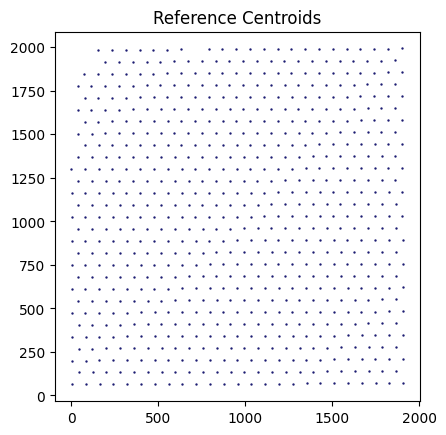

In [5]:
# load reference centroids
ref_cents_load = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids100.npy')), allow_pickle=True)
ref_cents_loaded = np.array(ref_cents_load)

# plot reference centroids
fig_ref = plt.figure('Reference Centroids')
plt.title('Reference Centroids')
plt.scatter(ref_cents_loaded[:,0], ref_cents_loaded[:,1], color = 'midnightblue', s = 0.5)
plt.gca().set_aspect('equal')
plt.show()

plot live centroids

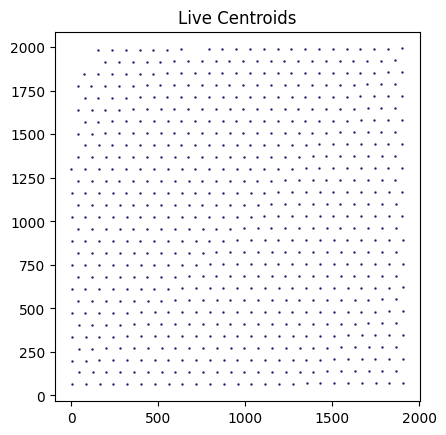

In [6]:
i = 103
live_cents_loaded = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids{i}.npy')))

# plot the live centeroids
fig_live = plt.figure('Live Centroids')
plt.title('Live Centroids')
plt.scatter(live_cents_loaded[:,0], live_cents_loaded[:,1], color = 'midnightblue', s = 0.5)
plt.gca().set_aspect('equal')
plt.show()

Find and plot gradients

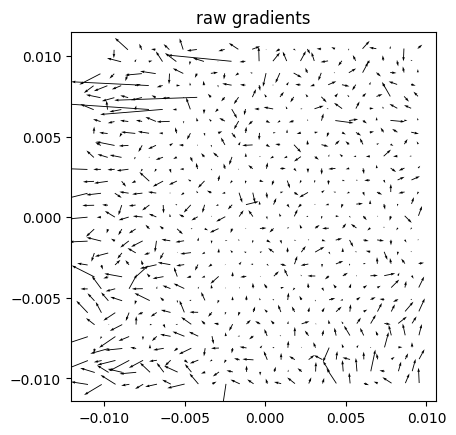

In [7]:
hsc_ref = HS_Centroids()
hsc_live = HS_Centroids()
hsc_ref.centroids = ref_cents_loaded
hsc_live.centroids = live_cents_loaded

hsg = HS_Gradients(hsc_ref, hsc_live)
hsg.origin = array([origin, origin])
hsg.pixel_size = pixel_size
hsg.magnification = magnification
hsg.construct_gradients()
raw_gradients = hsg.gradients

# plot gradients
plt.title('raw gradients')
plt.gca().set_aspect('equal')
plt.quiver(raw_gradients[:,2], raw_gradients[:,3], raw_gradients[:,0], raw_gradients[:,1])
plt.show()

Remove nasty gradients

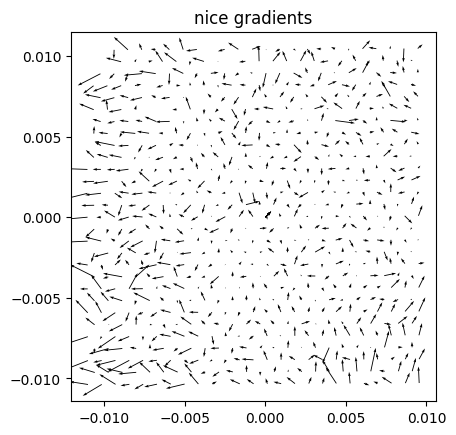

In [8]:
# nice gradients
nice_grads = remove_nasty_gradients(raw_gradients, factor = 5)
hsg_ng = HS_Gradients()
hsg.origin = array([origin, origin])
hsg.pixel_size = pixel_size
hsg.magnification = magnification
hsg_ng.gradients = nice_grads
hsg_ng.final_centroids = nice_grads[:,2:]

# plot gradients
plt.title('nice gradients')
plt.gca().set_aspect('equal')
plt.quiver(nice_grads[:,2], nice_grads[:,3], nice_grads[:,0], nice_grads[:,1])
plt.show()

Remove prism

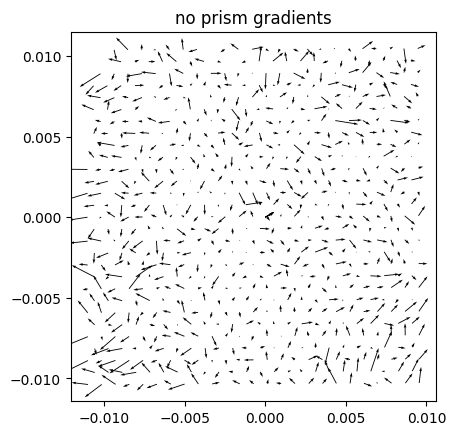

In [9]:
# numerical method of removing prism
prism_x = np.mean(hsg_ng.gradients[:, 0])
prism_y = np.mean(hsg_ng.gradients[:, 1])

hsg_noprism = hsg_ng

hsg_noprism.gradients[:, 0] = hsg_ng.gradients[:, 0] - prism_x
hsg_noprism.gradients[:, 1] = hsg_ng.gradients[:, 1] - prism_y

no_prism_grads = hsg_noprism.gradients

np.save(os.path.join(file_path, os.path.join(folder_name, f'gradients')), no_prism_grads)

plt.title('no prism gradients')
plt.gca().set_aspect('equal')
plt.quiver(no_prism_grads[:,2], no_prism_grads[:,3], no_prism_grads[:,0], no_prism_grads[:,1],)
plt.show()


Calculate the wavefront

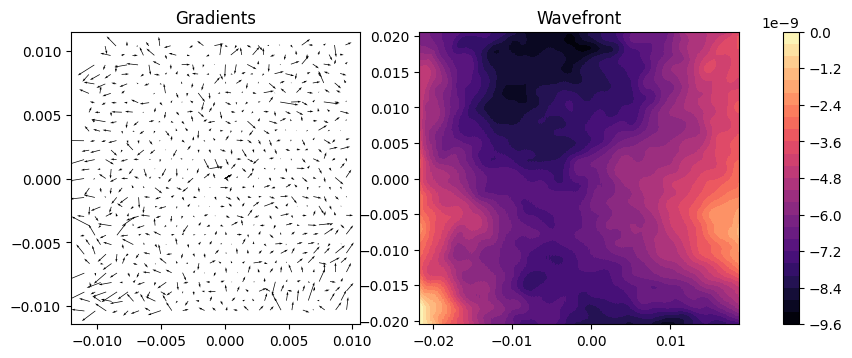

In [10]:
# calculate wavefront
wf_noprism_inv = HSM_WFN.calculate_wf_from_hsgradients(hsg_noprism, to_interpolate = False)
wf_noprism = -wf_noprism_inv

np.save(os.path.join(file_path, os.path.join(folder_name, f'wfn')), wf_noprism)
plot_gradients_and_wf(hsg_noprism, wf_noprism, 'Numerical without Prism')

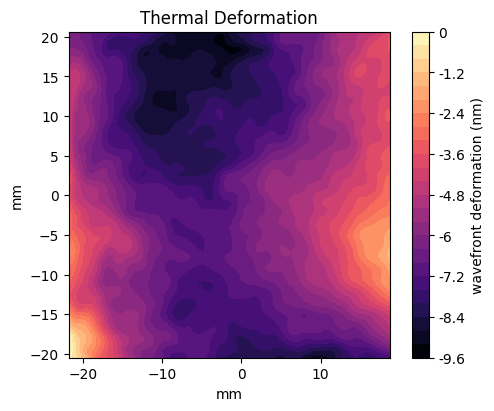

In [11]:
# format axes
gspacing = 4 * hsg_noprism.pixel_size

limits = {}
limits["x"] = array(
     [hsg_noprism.gradients[:,2].min() - gspacing, hsg_noprism.gradients[:,2].max() + gspacing]
)

limits["y"] = array(
    [hsg_noprism.gradients[:,3].min() - gspacing, hsg_noprism.gradients[:,3].max() + gspacing]
)

xaxis = np.arange(limits["x"][0], limits["x"][1], gspacing) * magnification * 1e3
yaxis = np.arange(limits["y"][0], limits["y"][1], gspacing) * magnification * 1e3

# Gaussian fit to the data
xm, ym = np.meshgrid(xaxis, yaxis)
xmym = (xm, ym)
p0 = np.array((1e-8, 0, 0, 25, 25, -1e-8))

# popt, pcov = apply_gauss_fit(np.ravel(wf_noprism), xmym, p0)
# print(*popt)
# data_fitted = np.reshape(twoD_Gaussian((xm, ym), *popt), (np.shape(wf_noprism)[0], np.shape(wf_noprism)[1]))

plt.subplots(1, 1, figsize = (5.5, 4), layout = 'constrained')
plt.subplot(1, 1, 1)
plt.contourf(xaxis, yaxis, wf_noprism, cmap = 'magma', levels = 30)
plt.xlabel('mm')
plt.ylabel('mm')

# format colourbar
func = lambda x,pos: "{:g}".format(x*1e9)
fmt = matplotlib.ticker.FuncFormatter(func)
cbar1 = plt.colorbar(format=fmt)
cbar1.set_label('wavefront deformation (nm)')

# plt.contour(xaxis, yaxis, data_fitted, cmap = 'Greys', levels = 15)
# cbar2 = plt.colorbar(format=fmt)
# cbar2.set_label('Gaussian fit to deformation (nm)')
# plt.gca().invert_yaxis()
plt.title('Thermal Deformation')
plt.savefig(f'wavefront_translation_{translation}')
plt.gca().set_aspect('equal')
plt.show()

deformation over time (ref = cents 0)

In [12]:
run = False

if run == True:
    max_def = np.zeros(150)

    ref_cents_load = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids29.npy')), allow_pickle=True)
    ref_cents_loaded = np.array(ref_cents_load)

    for i in range(30, 150):
        live_cents_each_load = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids{i}.npy')))
        live_cents_each = np.array(live_cents_each_load)

        # find gradients
        hsc_ref = HS_Centroids()
        hsc_live = HS_Centroids()
        hsc_ref.centroids = ref_cents_loaded
        hsc_live.centroids = live_cents_each

        hsg = HS_Gradients(hsc_ref, hsc_live)
        hsg.origin = array([origin, origin])
        hsg.pixel_size = pixel_size
        hsg.magnification = magnification
        hsg.construct_gradients()
        raw_gradients = hsg.gradients

        # remove nasty gradients
        nice_grads = remove_nasty_gradients(raw_gradients, factor = 5)
        hsg_ng = HS_Gradients()
        hsg.origin = array([origin, origin])
        hsg.pixel_size = pixel_size
        hsg.magnification = magnification
        hsg_ng.gradients = nice_grads
        hsg_ng.final_centroids = nice_grads[:,2:]

        # numerical method of removing prism
        prism_x = np.mean(hsg_ng.gradients[:, 0])
        prism_y = np.mean(hsg_ng.gradients[:, 1])

        hsg_noprism = hsg_ng

        hsg_noprism.gradients[:, 0] = hsg_ng.gradients[:, 0] - prism_x
        hsg_noprism.gradients[:, 1] = hsg_ng.gradients[:, 1] - prism_y

        no_prism_grads = hsg_noprism.gradients

        # find wavefront
        wf_noprism_inv = HSM_WFN.calculate_wf_from_hsgradients(hsg_noprism, to_interpolate = False)
        wf_noprism = -wf_noprism_inv

        # amplitude of deformation
        deformation_amplitude = np.min(wf_noprism)
        print(i, ' amplitude = ', deformation_amplitude)
        max_def[i] = deformation_amplitude
    

In [5]:
np.save(os.path.join(file_path, os.path.join(folder_name, f'max_def_ac_30+')), max_def)

Plot temperature of camera during warm up and idle

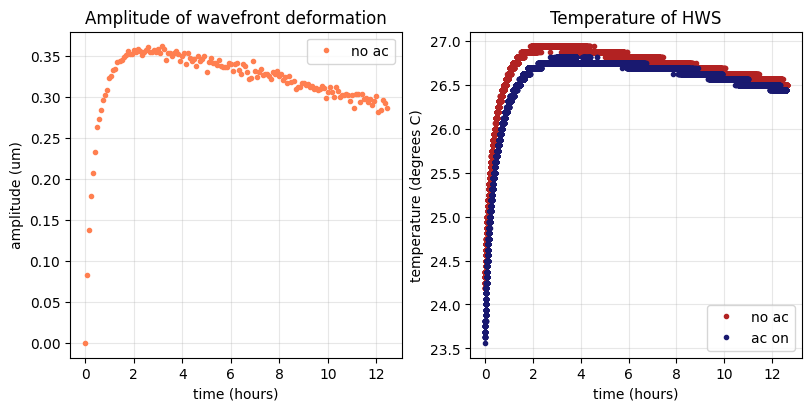

In [ ]:
# It can be helpful to know weather the camera has reached a stable temperature. If it has not, this adds uncertainty to the measurments.

# load data to plot
warm_up_1 = np.load(os.path.join(file_path, os.path.join('cents_over_time_15_09', 'camera_temperature.npy')))
warm_up_2 = np.load(os.path.join(file_path, os.path.join('cents_over_time_16_09', 'camera_temperature.npy')))

max_def_1 = np.load(os.path.join(file_path, os.path.join('cents_over_time_15_09', 'max_def_ac.npy')))
# max_def_2 = np.load(os.path.join(file_path, os.path.join('cents_over_time_16_09', 'max_def_ac_30+.npy')))

# warm up
initial_time_1 = warm_up_1[0, 0, 0] # time when data recording commenced
seconds_1 = warm_up_1[0, 0, :] - initial_time_1 # rescale x axis so time zero is when data recording began
degrees_1 = warm_up_1[1, 0, :] # the temperature

# warm up
initial_time_2 = warm_up_2[0, 0, 0] # time when data recording commenced
seconds_2 = warm_up_2[0, 0, :] - initial_time_2 # rescale x axis so time zero is when data recording began
degrees_2 = warm_up_2[1, 0, :] # the temperature

plt.subplots(1, 2, layout = 'constrained', figsize = (8, 4))

# amplitude of deformation
plt.subplot(1, 2, 1)
xaxis = np.arange(150)*5/60 # hours
plt.plot(xaxis, -max_def_1*10**6, '.', color = 'coral', label = 'no ac')
plt.plot(xaxis, -max_def_2*10**6, '.', color = 'cornflowerblue', label = 'ac on')
plt.title('Amplitude of wavefront deformation')
plt.xlabel('time (hours)')
plt.ylabel('amplitude (um)')
# plt.gca().invert_xaxis()
plt.grid(alpha = 0.3)
plt.legend()

# temperature of camera
plt.subplot(1, 2, 2)
plt.plot(seconds_1/60/60, degrees_1, '.', color = 'firebrick', label = 'no ac')
plt.plot(seconds_2/60/60, degrees_2, '.', color = 'midnightblue', label = 'ac on')
plt.title('Temperature of HWS')
plt.xlabel('time (hours)')
plt.ylabel('temperature (degrees C)')
plt.grid(alpha = 0.3)
plt.legend()

plt.show()


compare all cents to all others

In [162]:
def each_wavefront_amplitude(N, M):
    '''Find the wavefront deformation between two sets of centroids
    N, M label which centroids are used'''

    ref_cents_load = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids{N}.npy')), allow_pickle=True)
    ref_cents_loaded = np.array(ref_cents_load)

    live_cents_each_load = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids{M}.npy')))
    live_cents_each = np.array(live_cents_each_load)

    # find gradients
    hsc_ref = HS_Centroids()
    hsc_live = HS_Centroids()
    hsc_ref.centroids = ref_cents_loaded
    hsc_live.centroids = live_cents_each

    hsg = HS_Gradients(hsc_ref, hsc_live)
    hsg.origin = array([origin, origin])
    hsg.pixel_size = pixel_size
    hsg.magnification = magnification
    hsg.construct_gradients()
    raw_gradients = hsg.gradients

    # remove nasty gradients
    nice_grads = remove_nasty_gradients(raw_gradients, factor = 5)
    hsg_ng = HS_Gradients()
    hsg.origin = array([origin, origin])
    hsg.pixel_size = pixel_size
    hsg.magnification = magnification
    hsg_ng.gradients = nice_grads
    hsg_ng.final_centroids = nice_grads[:,2:]

    # numerical method of removing prism
    prism_x = np.mean(hsg_ng.gradients[:, 0])
    prism_y = np.mean(hsg_ng.gradients[:, 1])

    hsg_noprism = hsg_ng

    hsg_noprism.gradients[:, 0] = hsg_ng.gradients[:, 0] - prism_x
    hsg_noprism.gradients[:, 1] = hsg_ng.gradients[:, 1] - prism_y

    # find wavefront
    wf_noprism_inv = HSM_WFN.calculate_wf_from_hsgradients(hsg_noprism, to_interpolate = False)
    wf_noprism = -wf_noprism_inv

    # amplitude of deformation
    deformation_amplitude = np.min(wf_noprism)
    return deformation_amplitude

calculate max deformation between each data set and all others (Warning, takes ~ 20 h to run)

In [ ]:
# number of centroid sets
C = 149

max_amplitude_array = np.zeros((C, C))
M = C

start_time = time.time()

for N in range(C):
    for M in range(C):
        if M == N:
            print(N,M)
        elif max_amplitude_array[M,N] != 0:
            print(N,M,'-')
        else:
            max_amplitude_array[N,M] = each_wavefront_amplitude(N,M)
            print(N,M)
    M = M - 1

end_time = time.time()
time_taken = (end_time-start_time)/60

print('time taken =', time_taken, 'min')

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
1 0 -
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44

In [143]:
no_cents_have = C*C
no_cents_want = 150*150
time_per_no_cents = time_taken/no_cents_have
time_for_cents = time_per_no_cents * no_cents_want
print(time_for_cents/60, 'hours')

14.834566235542297 hours


In [165]:
np.save(os.path.join(file_path, os.path.join(folder_name, f'all_wf_amplitudes')), max_amplitude_array)

In [4]:
max_amplitude_array = np.load(os.path.join(file_path, os.path.join(folder_name, f'all_wf_amplitudes.npy')))

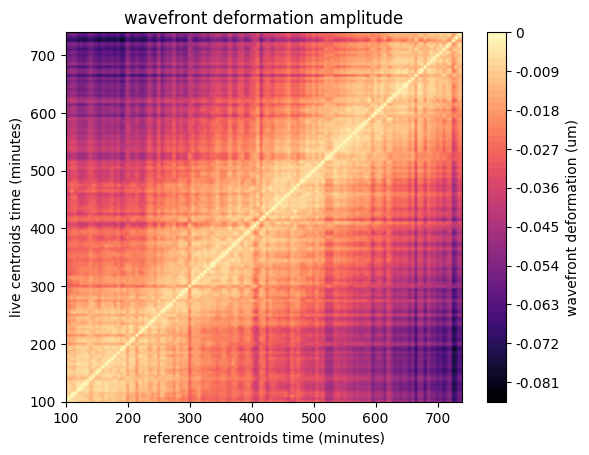

In [18]:
plot_it = max_amplitude_array + max_amplitude_array.T

xaxis = np.linspace(0, 740, 149)
yaxis = np.linspace(0, 740, 149)

plt.contourf(xaxis[20:149], yaxis[20:149], plot_it[20:149, 20:149], levels = 60, cmap = 'magma')

# format colourbar
func = lambda x,pos: "{:g}".format(x*1e6)
fmt = matplotlib.ticker.FuncFormatter(func)
cbar1 = plt.colorbar(format=fmt)
cbar1.set_label('wavefront deformation (um)')

plt.xlabel('reference centroids time (minutes)')
plt.ylabel('live centroids time (minutes)')

plt.title('wavefront deformation amplitude')

plt.show()

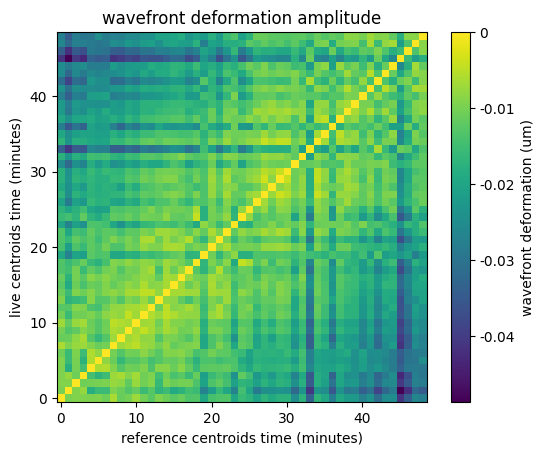

In [197]:
plot_it = max_amplitude_array[100:149, 100:149] + max_amplitude_array[100:149, 100:149].T

# xaxis = np.linspace(0, 740, 149)
# yaxis = np.linspace(0, 740, 149)

# plt.contourf(plot_it, levels = 100, cmap = 'magma')
plt.imshow(plot_it)

# format colourbar
func = lambda x,pos: "{:g}".format(x*1e6)
fmt = matplotlib.ticker.FuncFormatter(func)
cbar1 = plt.colorbar(format=fmt)
cbar1.set_label('wavefront deformation (um)')

plt.xlabel('reference centroids time (minutes)')
plt.ylabel('live centroids time (minutes)')
plt.gca().invert_yaxis()

plt.title('wavefront deformation amplitude')

plt.show()

wavefront over time after thermal equilibrium

In [236]:
def each_wavefront(N, M):
    '''Find the wavefront deformation between two sets of centroids
    N, M label which centroids are used'''

    ref_cents_load = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids{N}.npy')), allow_pickle=True)
    ref_cents_loaded = np.array(ref_cents_load)

    live_cents_each_load = np.load(os.path.join(file_path, os.path.join(folder_name, f'centroids{M}.npy')))
    live_cents_each = np.array(live_cents_each_load)

    # find gradients
    hsc_ref = HS_Centroids()
    hsc_live = HS_Centroids()
    hsc_ref.centroids = ref_cents_loaded
    hsc_live.centroids = live_cents_each

    hsg = HS_Gradients(hsc_ref, hsc_live)
    hsg.origin = array([origin, origin])
    hsg.pixel_size = pixel_size
    hsg.magnification = magnification
    hsg.construct_gradients()
    raw_gradients = hsg.gradients

    # remove nasty gradients
    nice_grads = remove_nasty_gradients(raw_gradients, factor = 5)
    hsg_ng = HS_Gradients()
    hsg.origin = array([origin, origin])
    hsg.pixel_size = pixel_size
    hsg.magnification = magnification
    hsg_ng.gradients = nice_grads
    hsg_ng.final_centroids = nice_grads[:,2:]

    # numerical method of removing prism
    prism_x = np.mean(hsg_ng.gradients[:, 0])
    prism_y = np.mean(hsg_ng.gradients[:, 1])

    hsg_noprism = hsg_ng

    hsg_noprism.gradients[:, 0] = hsg_ng.gradients[:, 0] - prism_x
    hsg_noprism.gradients[:, 1] = hsg_ng.gradients[:, 1] - prism_y

    # find wavefront
    wf_noprism_inv = HSM_WFN.calculate_wf_from_hsgradients(hsg_noprism, to_interpolate = False)
    wf_noprism = -wf_noprism_inv

    return wf_noprism

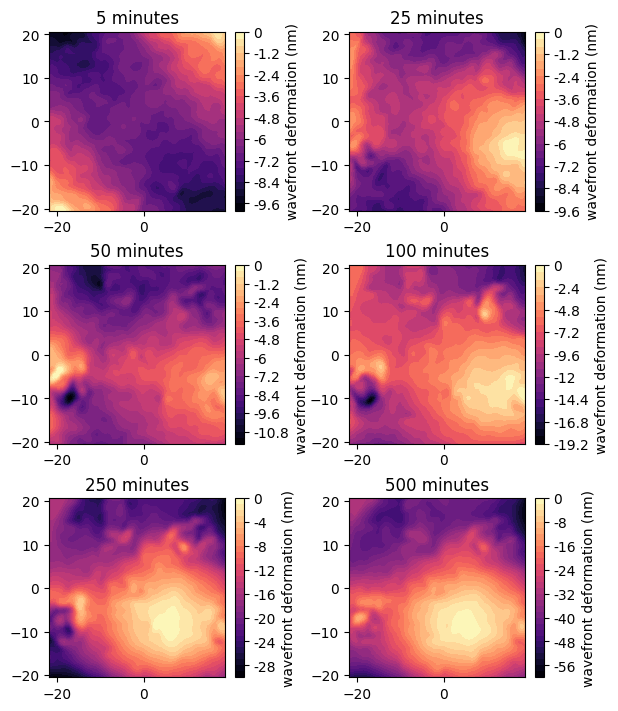

In [315]:
plt.subplots(3, 2, layout = 'constrained', figsize = (6, 7))
plot_steps = np.array([49, 53, 58, 68, 98, 148,])
plot_times = np.array([5, 25, 50, 100, 250, 500])

# plot_steps = np.array([37, 38, 39, 40, 41])
# plot_times = np.array([5, 10, 15, 25, 30])

# format axes
gspacing = 4 * hsg_noprism.pixel_size

limits = {}
limits["x"] = array(
     [hsg_noprism.gradients[:,2].min() - gspacing, hsg_noprism.gradients[:,2].max() + gspacing]
)

limits["y"] = array(
    [hsg_noprism.gradients[:,3].min() - gspacing, hsg_noprism.gradients[:,3].max() + gspacing]
)

xaxis = np.arange(limits["x"][0], limits["x"][1], gspacing) * magnification * 1e3
yaxis = np.arange(limits["y"][0], limits["y"][1], gspacing) * magnification * 1e3

# format colourbar 
func = lambda x,pos: "{:g}".format(x*1e9)
fmt = matplotlib.ticker.FuncFormatter(func)

for i in range(6):
    i_cents = plot_steps[i]
    this_one = each_wavefront(48, i_cents)
    plt.subplot(3, 2, i+1)
    plt.contourf(xaxis, yaxis, this_one, cmap = 'magma', levels = 30)
    plt.title(f'{plot_times[i]} minutes')
    cbar1 = plt.colorbar(format=fmt)
    cbar1.set_label('wavefront deformation (nm)')
    plt.gca().set_aspect('equal')
plt.show()